In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import reduce

In [2]:
import matplotlib.font_manager as font_manager

# Add every font at the specified location
# font_dir = ["/Users/darioradecic/Downloads/Merriweather"]
# for font in font_manager.findSystemFonts(font_dir):
#     font_manager.fontManager.addfont(font)

# font_manager.get_font_names()


from matplotlib import rcParams

rcParams["font.family"] = "Lato"

sns.set_palette("colorblind")

In [3]:
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

In [4]:
run_results_det_optimized = joblib.load(
    "../results/run_2024-03-06_14:20:14_results.job"
)
run_model_det_optimized = joblib.load(
    "../results/run_2024-03-06_14:20:14_model.job"
)
m = run_model_det_optimized

In [6]:
true_pars = game.true_pars

number_of_samples = 10

iters = np.arange(0, run_results_det_optimized.estimates_array.shape[1])

In [7]:
run_results_det_optimized

Run(
  iteration=i32[10],
  key=u32[10,2],
  weights=f32[10,1000],
  particles_locations=f32[10,1000,4],
  max_iterations=i32[10],
  min_iterations=i32[10],
  std_threshold=f32[10],
  cov_array=f32[10,1000000,4,4],
  estimates_array=f32[10,1000000,4],
  times_array=f32[10,1000000]
)

In [8]:
m

physical_model(
  number_of_parameters=4,
  delta=0.12739334807998307,
  Omega=0.5,
  H0=f32[2,2],
  A=i32[2,2],
  sic_POVM_arr=c64[16,4,4],
  basis_elements=f32[4,4]
)

In [9]:
times = jnp.linspace(0, 150, 1000)


evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t))(times)
evolution_inverse_fim = jax.vmap(
    lambda t: jnp.linalg.inv(m.fim(true_pars, t))
)(times)

evolution_det_fim = jax.vmap(lambda t: jnp.linalg.det(m.fim(true_pars, t)))(
    times
)

evolution_norm_inverse_fim = jax.vmap(
    lambda t: jnp.linalg.norm(jnp.linalg.inv(m.fim(true_pars, t)))
)(times)

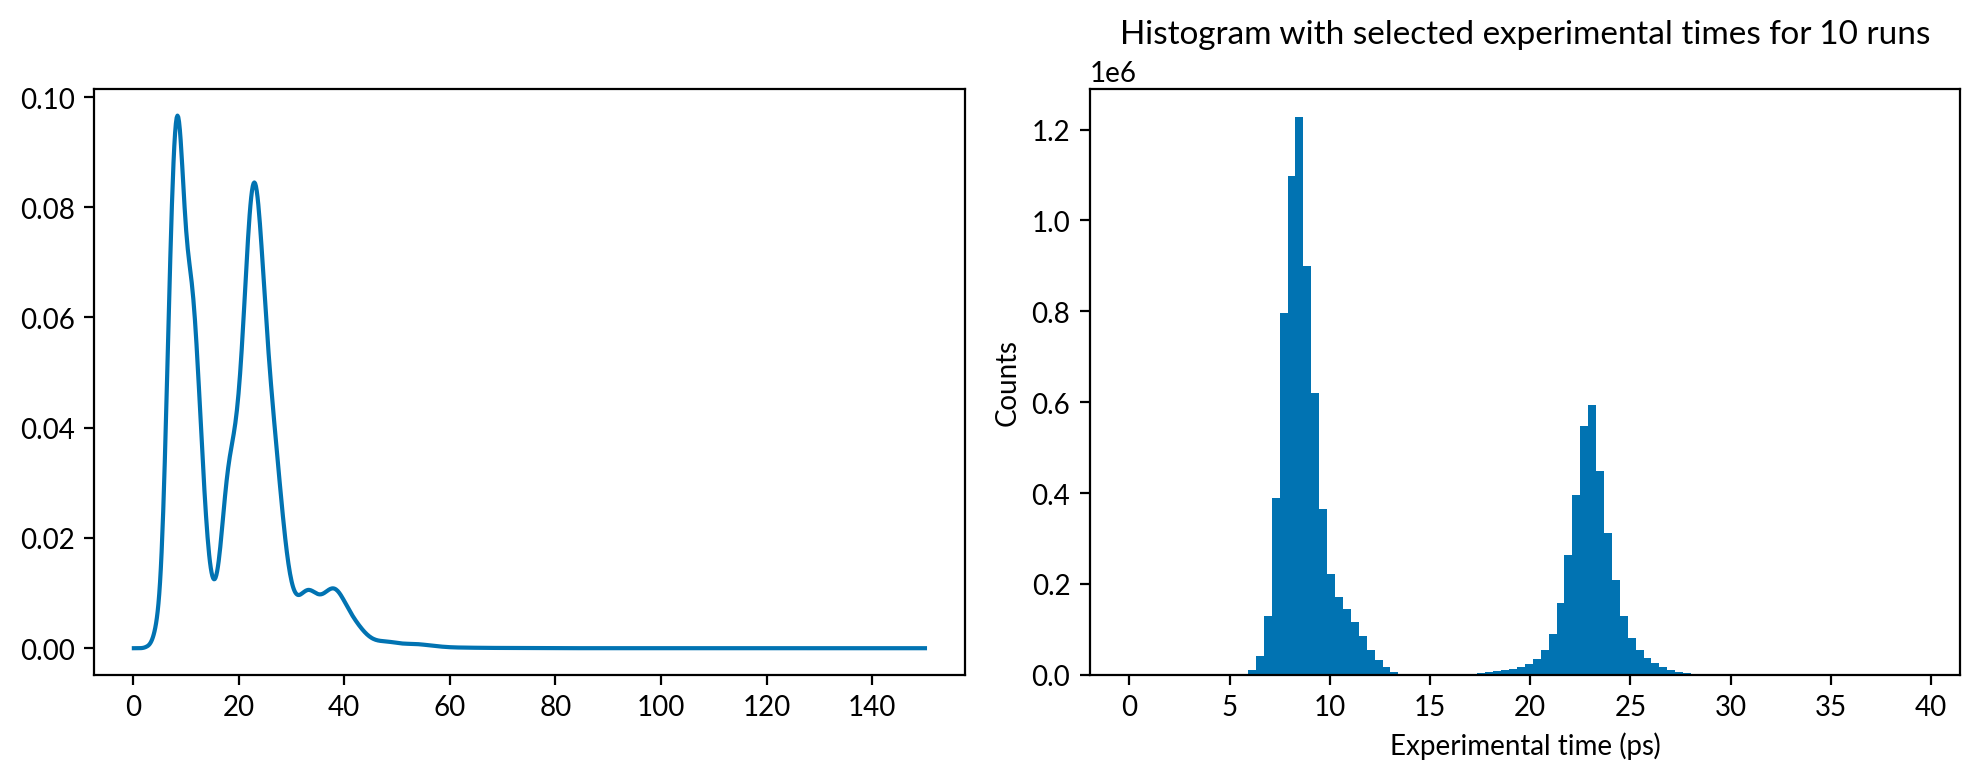

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)


ax1.plot(times, evolution_det_fim)


ax2.hist(np.array(run_results_det_optimized.times_array).flatten(), bins=100)
ax2.set_title(
    f"Histogram with selected experimental times for {number_of_samples} runs"
)
ax2.set_xlabel("Experimental time (ps)")
ax2.set_ylabel("Counts")

plt.tight_layout()
# plt.show()

In [11]:
all_times = np.array(run_results_det_optimized.times_array).flatten()

group_1 = all_times[all_times < 14]
group_2 = all_times[all_times > 14]
mu1 = group_1.mean()
mu2 = group_2.mean()

In [12]:
tindex_mu2 = np.abs(times[:] - mu2).argmin()
tindex_mu1 = np.abs(times[:] - mu1).argmin()

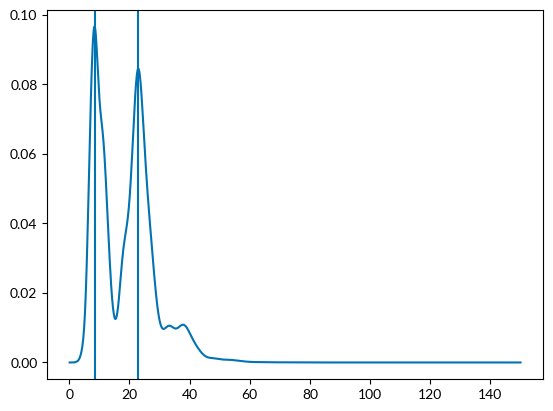

In [13]:
plt.plot(times[1:], evolution_det_fim[1:])
plt.axvline(times[tindex_mu1])
plt.axvline(times[tindex_mu2])

In [14]:
mean_mu = (
    1
    / 100000
    * (
        60000 * evolution_det_fim[tindex_mu1 - 1]
        + 40000 * evolution_det_fim[tindex_mu2 - 1]
    )
)

In [15]:
mean_mu

Array(0.09154704, dtype=float32)

In [16]:
evolution_det_fim[tindex_mu1]

Array(0.09547735, dtype=float32)

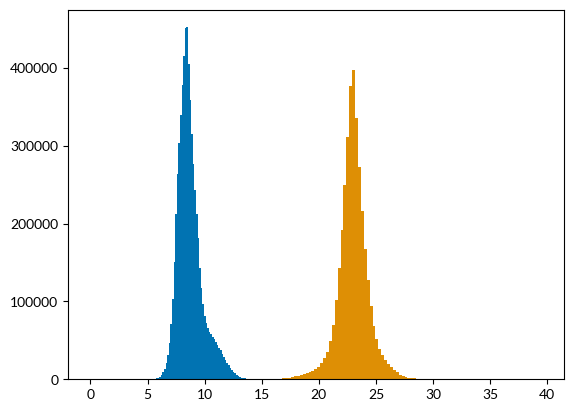

In [17]:
plt.hist(group_1, bins=100)
plt.hist(group_2, bins=100)

plt.show()

In [18]:
names_true

['$\\gamma ( - \\eta)$',
 '$\\gamma ( + \\eta)$',
 '$S ( - \\eta)$',
 '$S ( +\\eta)$']

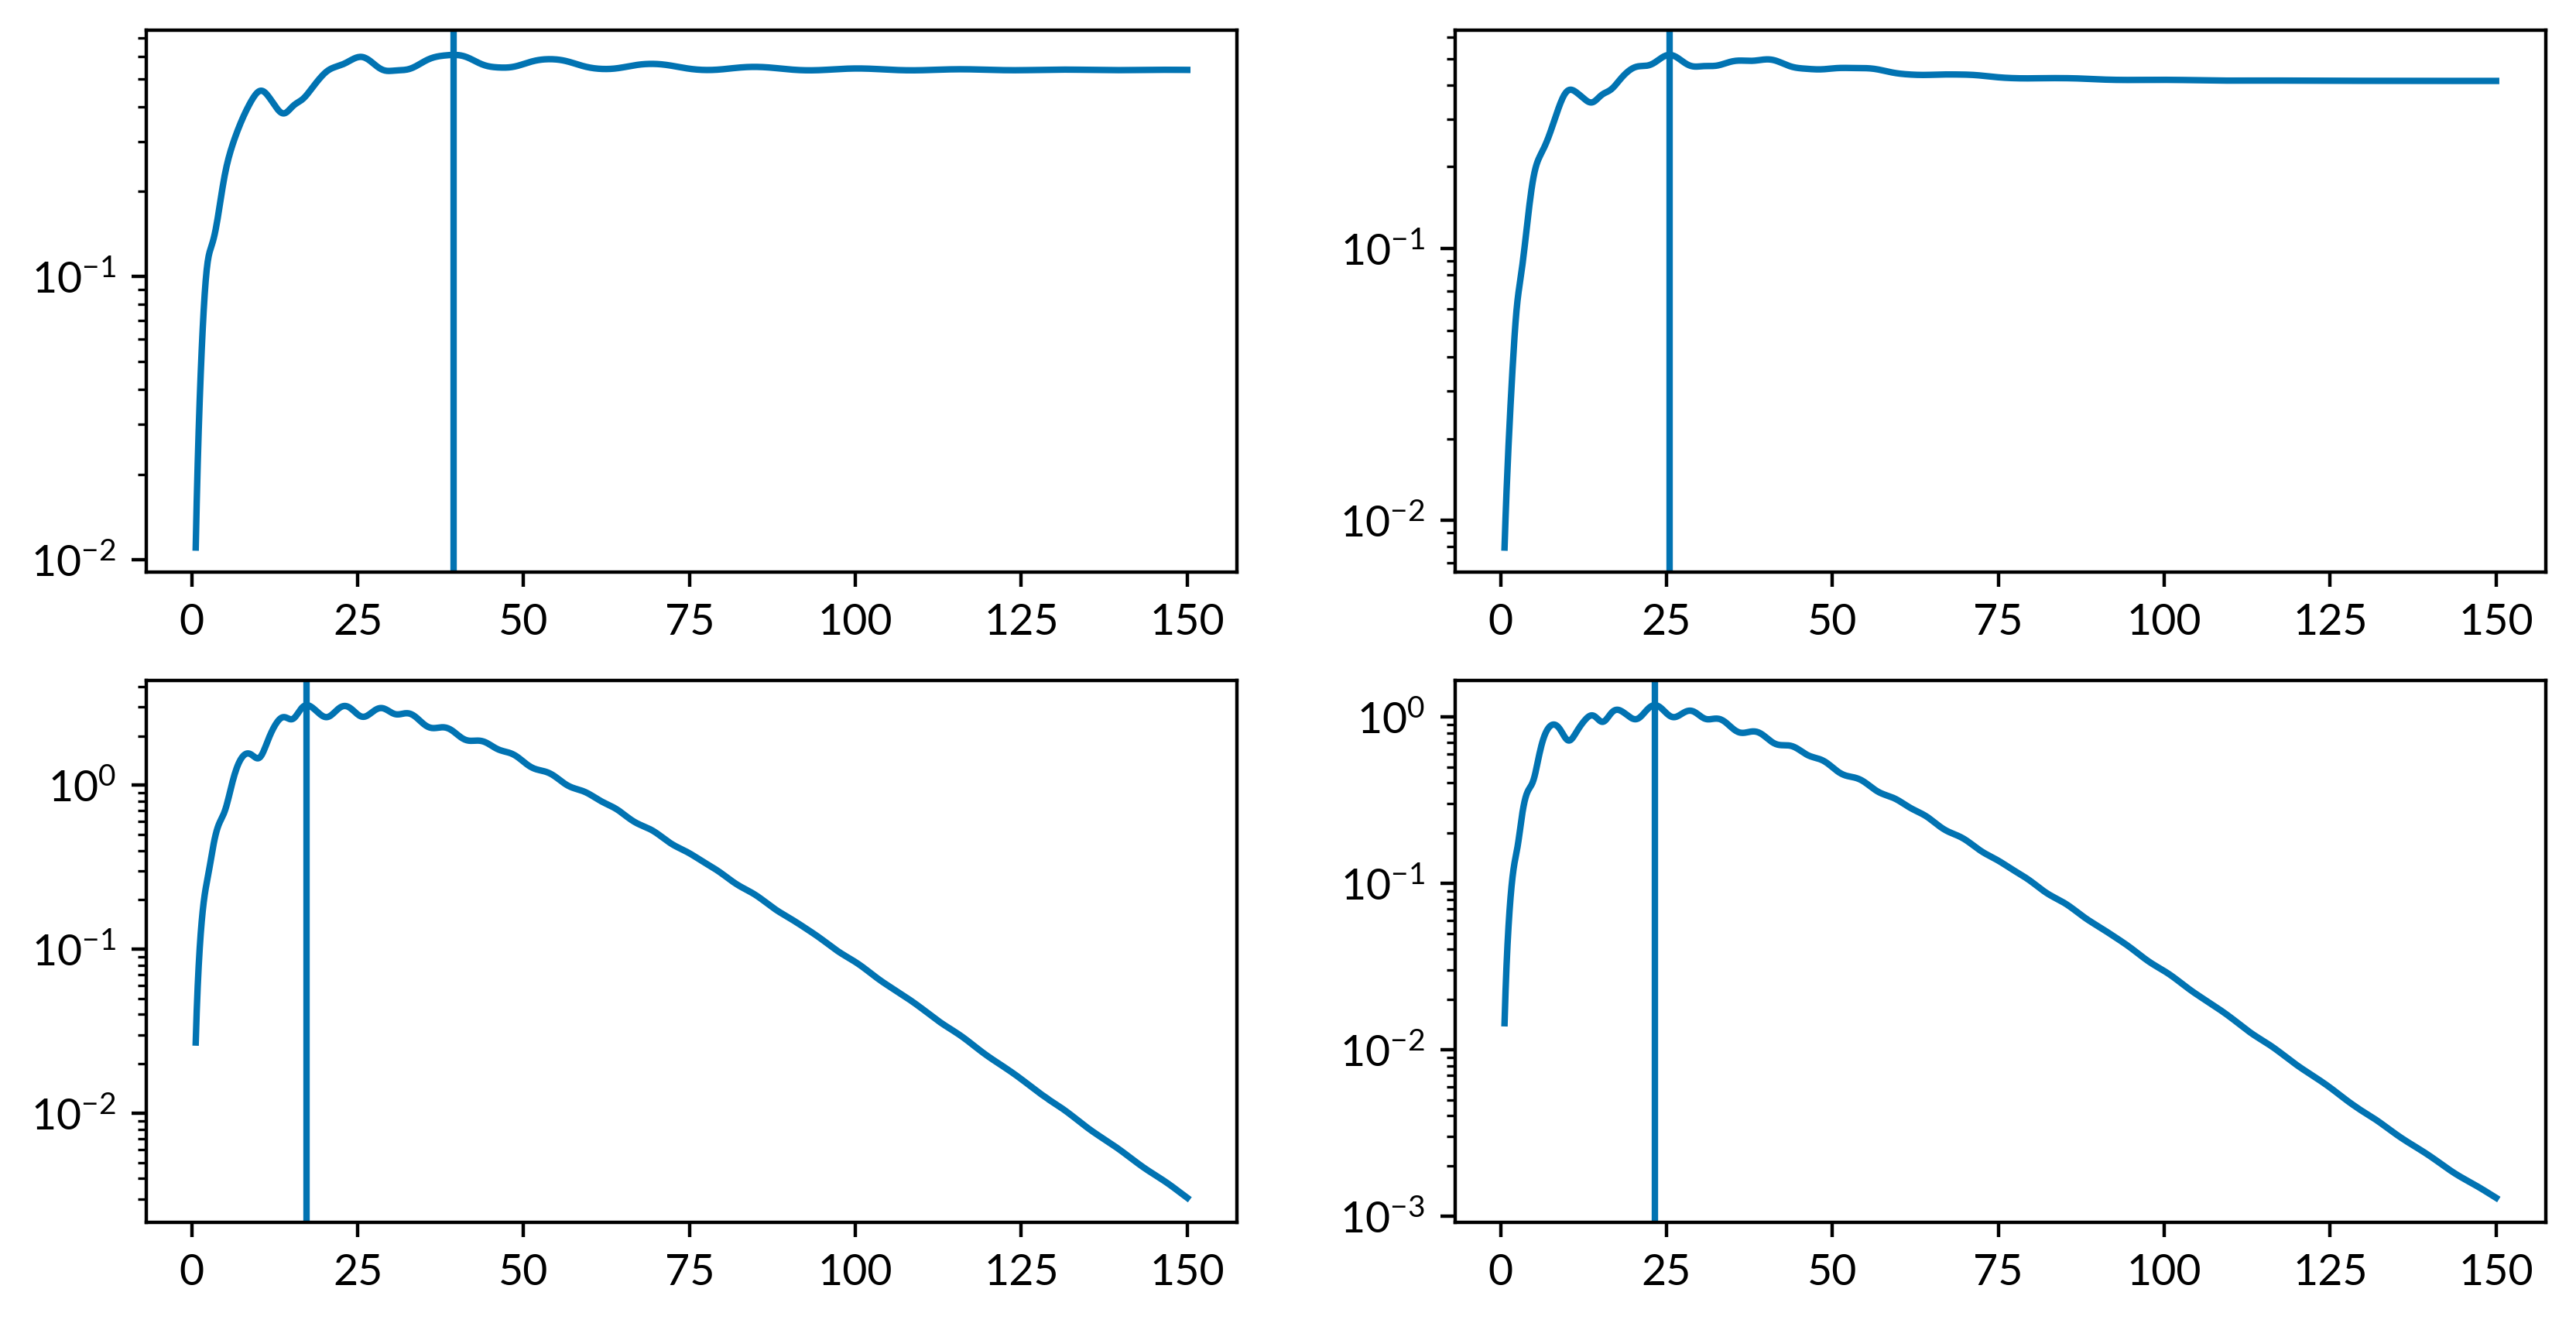

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=400)

for i, ax in enumerate(axs.flat):
    ax.plot(times[4:], evolution_fim[4:, i, i])
    ax.axvline(
        times[
            (
                np.diag(np.argmax(evolution_fim[1:,], axis=0))
                + 1 * np.array([1, 1, 1, 1])
            )[i]
        ]
    )
    # ax.set_xscale("log")
    ax.set_yscale("log")

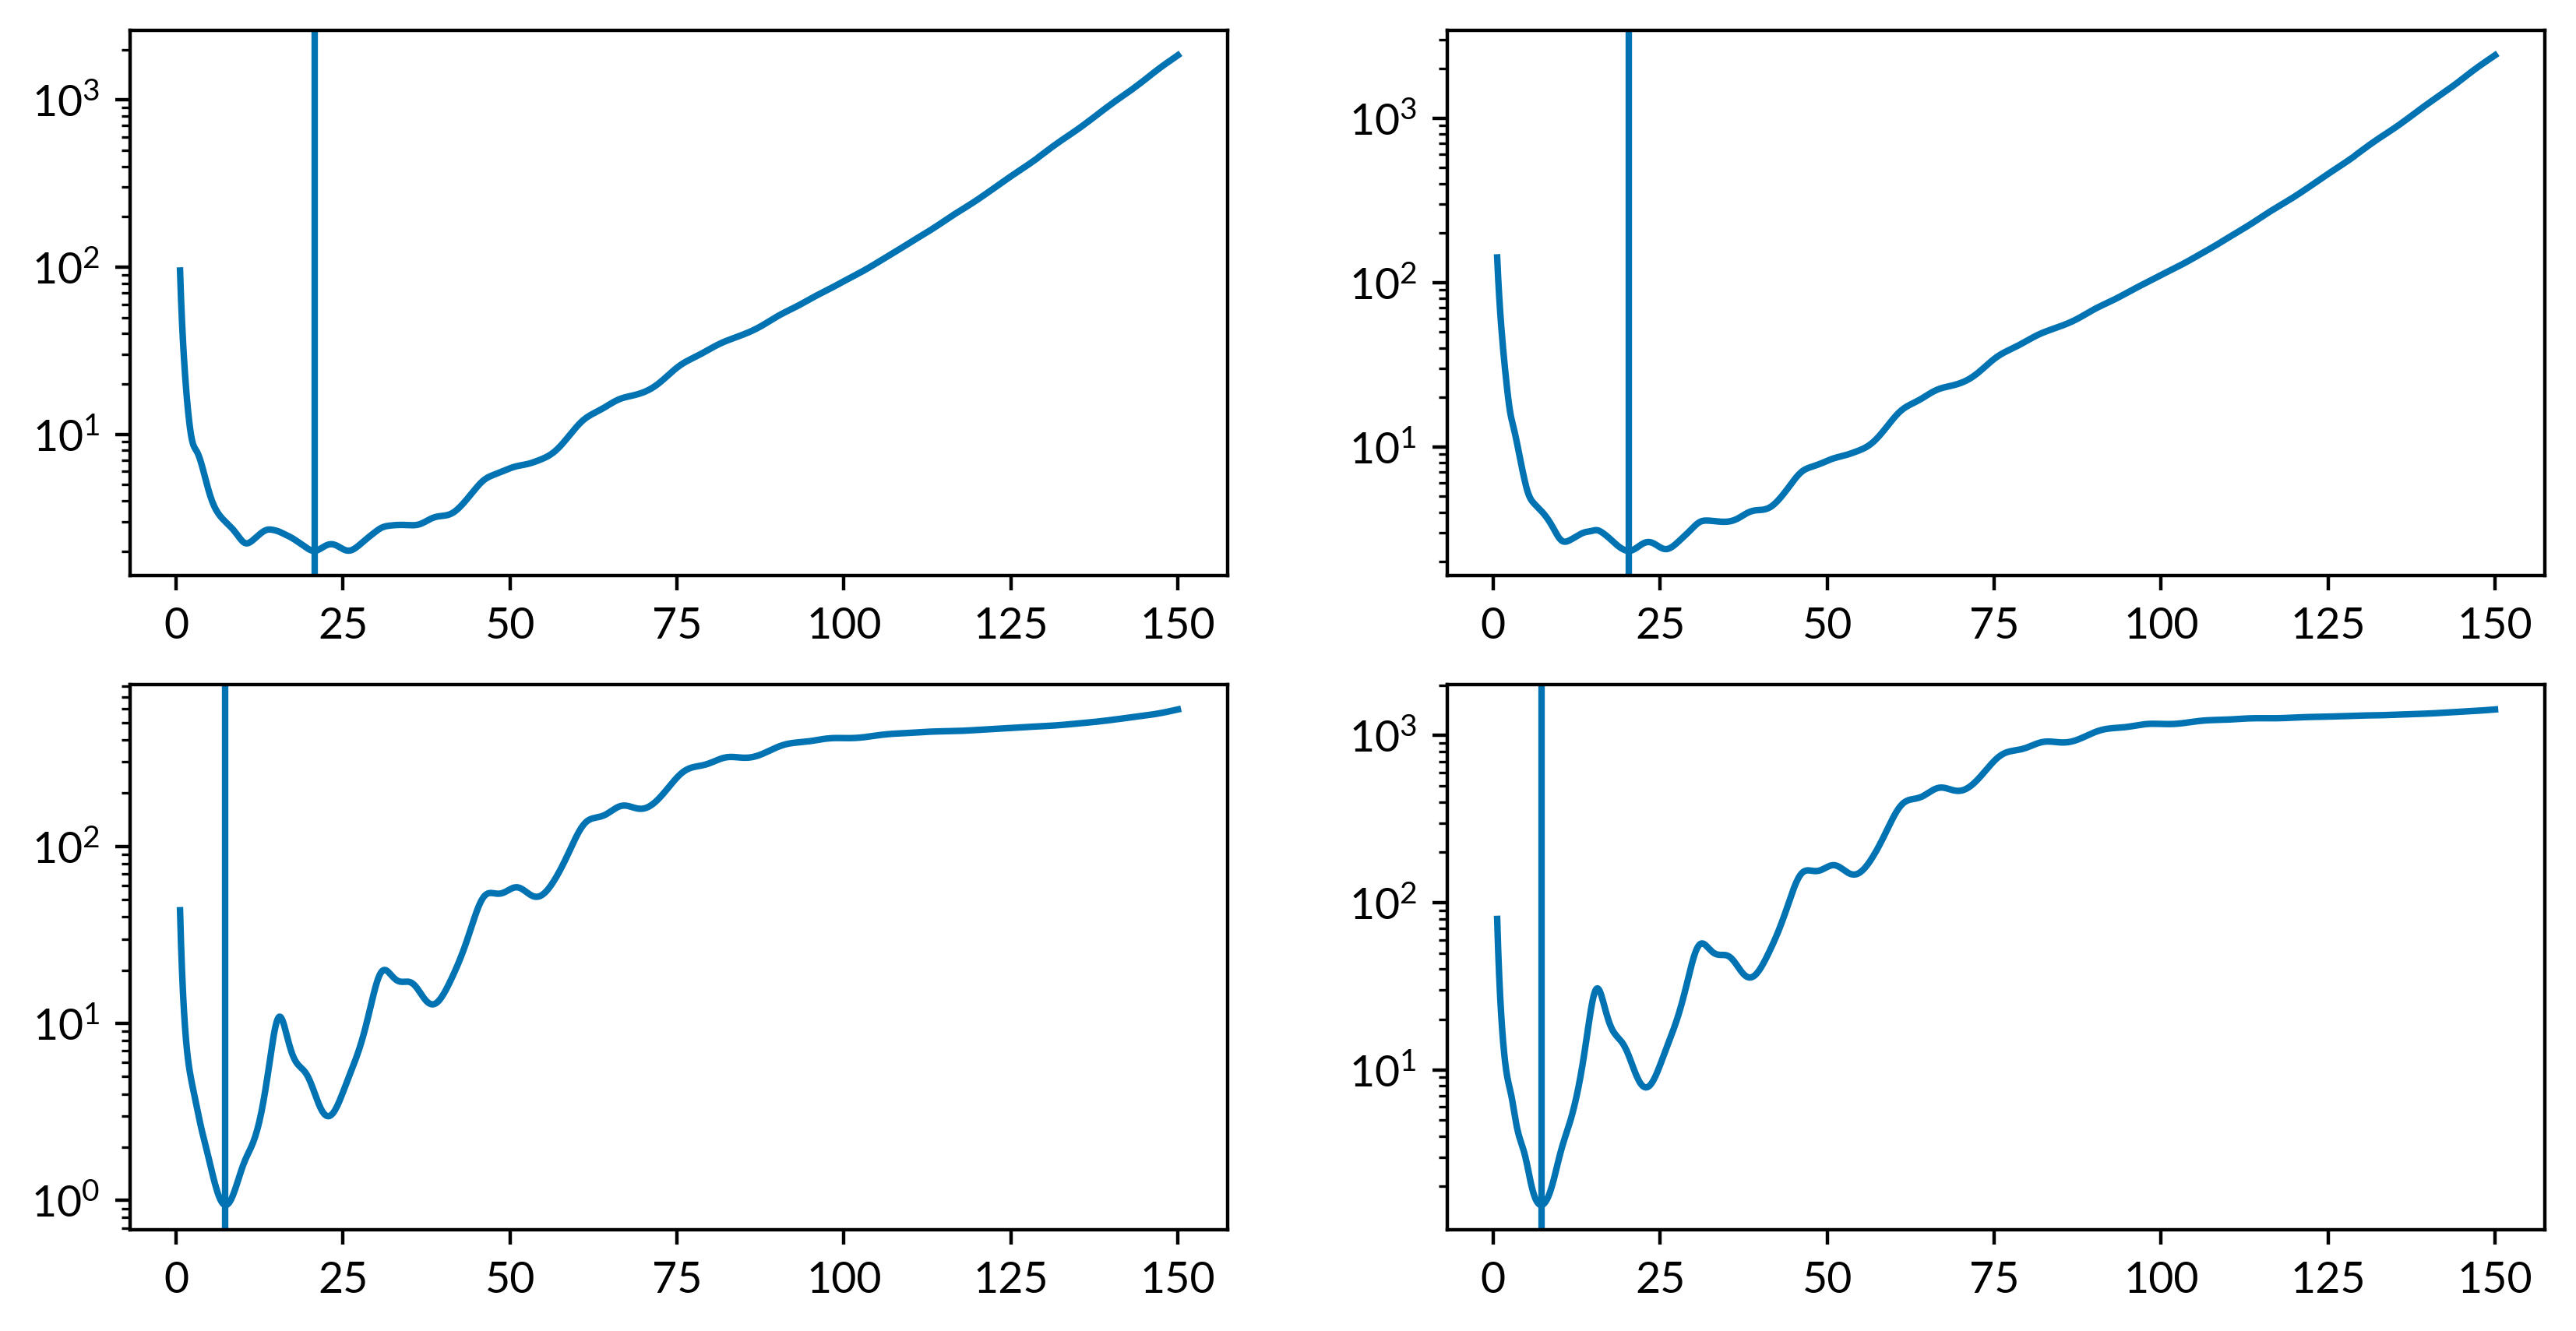

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=400)

for i, ax in enumerate(axs.flat):
    ax.plot(times[4:], evolution_inverse_fim[4:, i, i])
    ax.axvline(
        times[
            (
                np.diag(np.argmin(evolution_inverse_fim[1:,], axis=0))
                + 1 * np.array([1, 1, 1, 1])
            )[i]
        ]
    )
    # ax.set_xscale("log")
    ax.set_yscale("log")

In [21]:
times[
    np.diag(np.argmin(evolution_inverse_fim[1:], axis=0))
    + 1 * np.array([1, 1, 1, 1])
]

Array([20.72072  , 20.27027  ,  7.3573575,  7.207207 ], dtype=float32)

In [22]:
maxdet = np.nanmax(evolution_det_fim, axis=0)

In [23]:
min_inverse_fim = np.diag(np.nanmin(evolution_inverse_fim[1:], axis=0))

min_inverse_fim

array([2.0093334, 2.32725  , 0.9418543, 1.5490515], dtype=float32)

In [24]:
maxdet

0.09662487

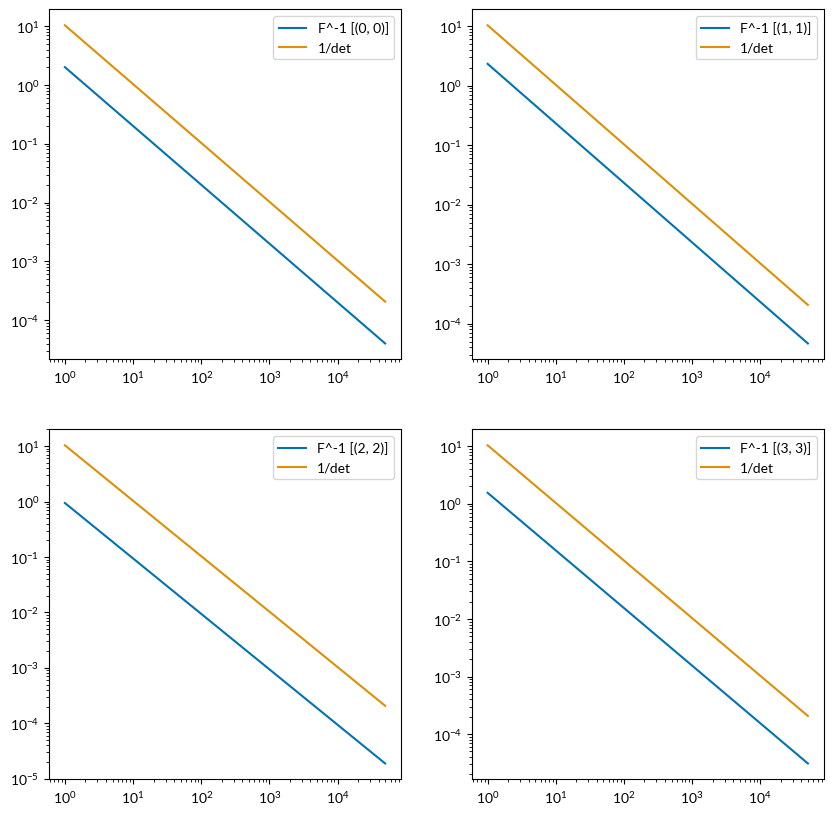

In [25]:
x_for_scaling = np.arange(1, 1e5, 5e4)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.plot(
        x_for_scaling,
        1 * min_inverse_fim[i] / x_for_scaling,
        label=f"F^-1 [{i, i}]",
    )
    ax.plot(x_for_scaling, 1 * 1 / maxdet / x_for_scaling, label="1/det")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()

# plt.legend()

In [26]:
cumulative_times_per_run[:, -1].max()

NameError: name 'cumulative_times_per_run' is not defined

In [31]:
df = run_results_det_optimized

cov_arr = df.cov_array[:, 1:]
cumulative_times_per_run = (vmap(jnp.cumsum, in_axes=(0))(df.times_array) * 1)[
    :, 1:
]

var_arr = vmap(vmap(lambda x: jnp.diag(x), in_axes=(0)), in_axes=(0))(cov_arr)

var_arr = np.array(var_arr)
cumulative_times_per_run = np.array(cumulative_times_per_run)

max_lim_bin = int(cumulative_times_per_run[:, -1].max() + 1)
no_bins = int(25)
limites_bins = np.arange(
    0.0,
    max_lim_bin,
    np.floor(max_lim_bin / no_bins),
)

In [33]:
cov_arr.shape

(10, 999999, 4, 4)

In [34]:
df.cov_array[0, 0]

Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

(array([1., 1., 0., 1., 1., 2., 2., 0., 0., 2.]),
 array([13200662., 13316078., 13431494., 13546909., 13662325., 13777741.,
        13893157., 14008573., 14123988., 14239404., 14354820.]),
 <BarContainer object of 10 artists>)

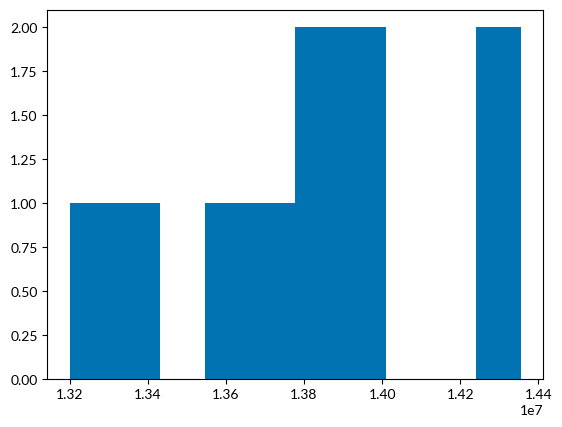

In [35]:
plt.hist(cumulative_times_per_run[:, -1])

In [36]:
def compute_mean_one_run(cum_times_i, cov_arr_i, limites_bins):
    indices_bins = np.digitize(cum_times_i, limites_bins)
    means = np.array(
        [
            np.nanmean(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )

    std_devs = np.array(
        [
            np.nanstd(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )
    return means, std_devs

In [37]:
all_mean_stds = np.array(
    [
        compute_mean_one_run(
            cumulative_times_per_run[j], cov_arr[j], limites_bins
        )
        for j in range(len(cov_arr))
    ]
).swapaxes(0, 1)

/tmp/ipykernel_2384149/313729249.py:5: RuntimeWarning: Mean of empty slice
  np.nanmean(cov_arr_i[indices_bins == i], axis=0)
/home/antonio/miniconda3/envs/jax_qdots/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [38]:
all_mean_agg_binned = np.nanmean(all_mean_stds, axis=1)[0]
all_std_agg_binned = np.nanstd(all_mean_stds, axis=1)[0]

In [39]:
x_times = np.linspace(0, max_lim_bin, len(all_mean_agg_binned[:]))

In [40]:
all_mean_stds[0].shape

(10, 25, 4, 4)

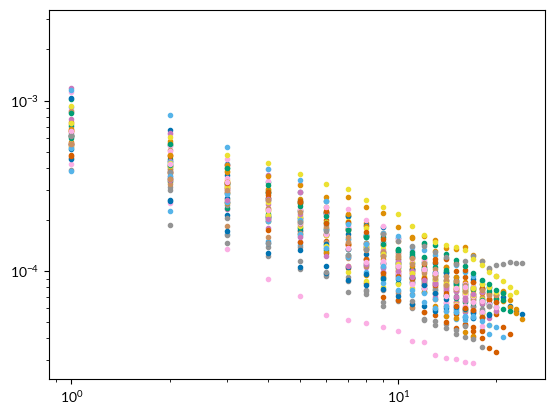

In [39]:
i = 2
# for i in range(4):
plt.plot(all_mean_stds[0, :, :, i, i].T, ".")
plt.xscale("log")
plt.yscale("log")

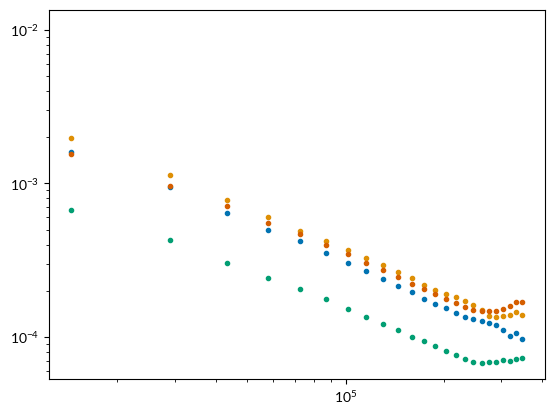

In [40]:
for i in range(4):

    plt.plot(x_times, all_mean_agg_binned[:, i, i], ".")

plt.xscale("log")
plt.yscale("log")

In [111]:
1 / jax.vmap(lambda x: jnp.diag(x))(evolution_fim)[1:]

Array([[ 627.35254  ,  456.93805  ,  630.8839   , 1158.6228   ],
       [ 258.23068  ,  247.62567  ,  151.41982  ,  281.83185  ],
       [ 143.01207  ,  169.14307  ,   66.13264  ,  123.76175  ],
       ...,
       [   1.8554715,    2.417312 ,  321.32187  ,  763.75946  ],
       [   1.8555881,    2.4173198,  324.6783   ,  770.28577  ],
       [   1.8557063,    2.41733  ,  328.03705  ,  776.8212   ]],      dtype=float32)

In [129]:
x_times = x_times / 1e9

/tmp/ipykernel_2384149/266599975.py:7: RuntimeWarning: divide by zero encountered in divide
  1 * min_inverse_fim[i] / (1 * 1 / 1 * x_times**1),
/tmp/ipykernel_2384149/266599975.py:12: RuntimeWarning: divide by zero encountered in divide
  1 / 1 * 1 / maxdet / (1 * 1 / 1 * x_times**1),


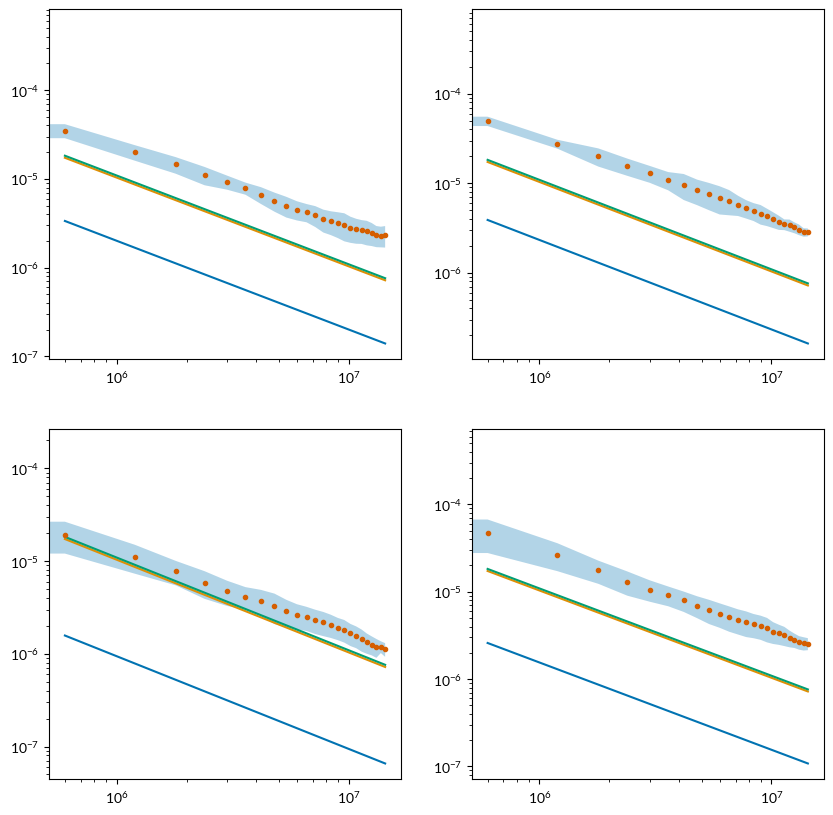

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):

    ax.plot(
        1 * x_times,
        1 * min_inverse_fim[i] / (1 * 1 / 1 * x_times**1),
        label=f"F^-1 [{i, i}]",
    )
    ax.plot(
        1 / 1 * x_times,
        1 / 1 * 1 / maxdet / (1 * 1 / 1 * x_times**1),
        label="1/det",
    )
    ax.plot(
        1 / 1 * x_times,
        1 / 1 / mean_mu / (1 * 1 / 1 * x_times**1),
        label="1/meandet",
    )

    ax.plot(
        x_times,
        all_mean_agg_binned[:, i, i],
        ".",
    )

    # ax.plot(
    #     x_times,
    #     det_mean_agg_binned[:, i, i],
    #     "-.",
    # )

    # ax.fill_between(
    #     # np.arange(len(all_mean_agg_binned[:, 0, 0])),
    #     np.linspace(0, max_lim_bin, len(det_mean_agg_binned[:, i, i])),
    #     det_mean_agg_binned[:, i, i] - det_std_agg_binned[:, i, i],
    #     det_mean_agg_binned[:, i, i] + det_std_agg_binned[:, i, i],
    #     alpha=0.3,
    # )

    ax.fill_between(
        # np.arange(len(all_mean_agg_binned[:, 0, 0])),
        x_times,
        all_mean_agg_binned[:, i, i] - all_std_agg_binned[:, i, i],
        all_mean_agg_binned[:, i, i] + all_std_agg_binned[:, i, i],
        alpha=0.3,
    )
    # ax.plot(x_times, det_opt_scaling)
    # ax.plot(x_times, inverse_matrix_scaling[:, i])
    ax.set_xscale("log")
    ax.set_yscale("log")

In [41]:
df

Run(
  iteration=i32[100],
  key=u32[100,2],
  weights=f32[100,1000],
  particles_locations=f32[100,1000,4],
  max_iterations=i32[100],
  min_iterations=i32[100],
  std_threshold=f32[100],
  cov_array=f32[100,6000,4,4],
  estimates_array=f32[100,6000,4],
  times_array=f32[100,6000]
)

Array([ 0.314216,  0.35833 ,  0.053851, -0.333695], dtype=float32)

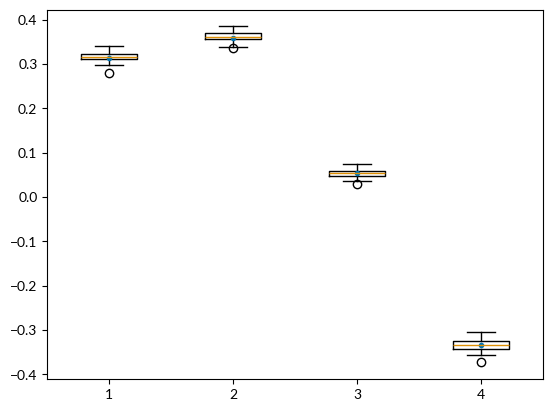

In [42]:
plt.boxplot(df.estimates_array[:, -1, :].T)
plt.plot(np.arange(1, 5), true_pars, ".")
true_pars

In [79]:
times[np.diag(np.argmin(1 / evolution_fim[1:], axis=0)) + 1]

Array([39.48949 , 25.525526, 17.267267, 23.273273], dtype=float32)

In [97]:
times[detlim2]

Array([78.07808], dtype=float32)

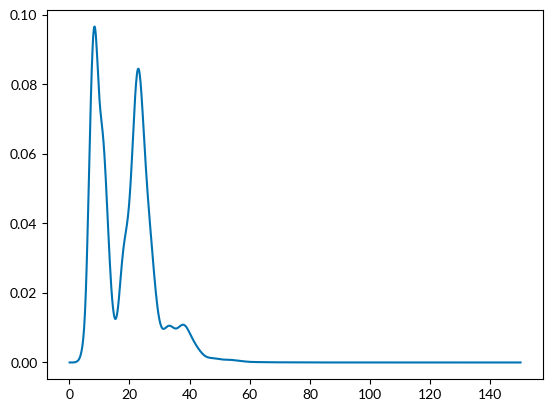

In [103]:
plt.plot(times, evolution_det_fim)

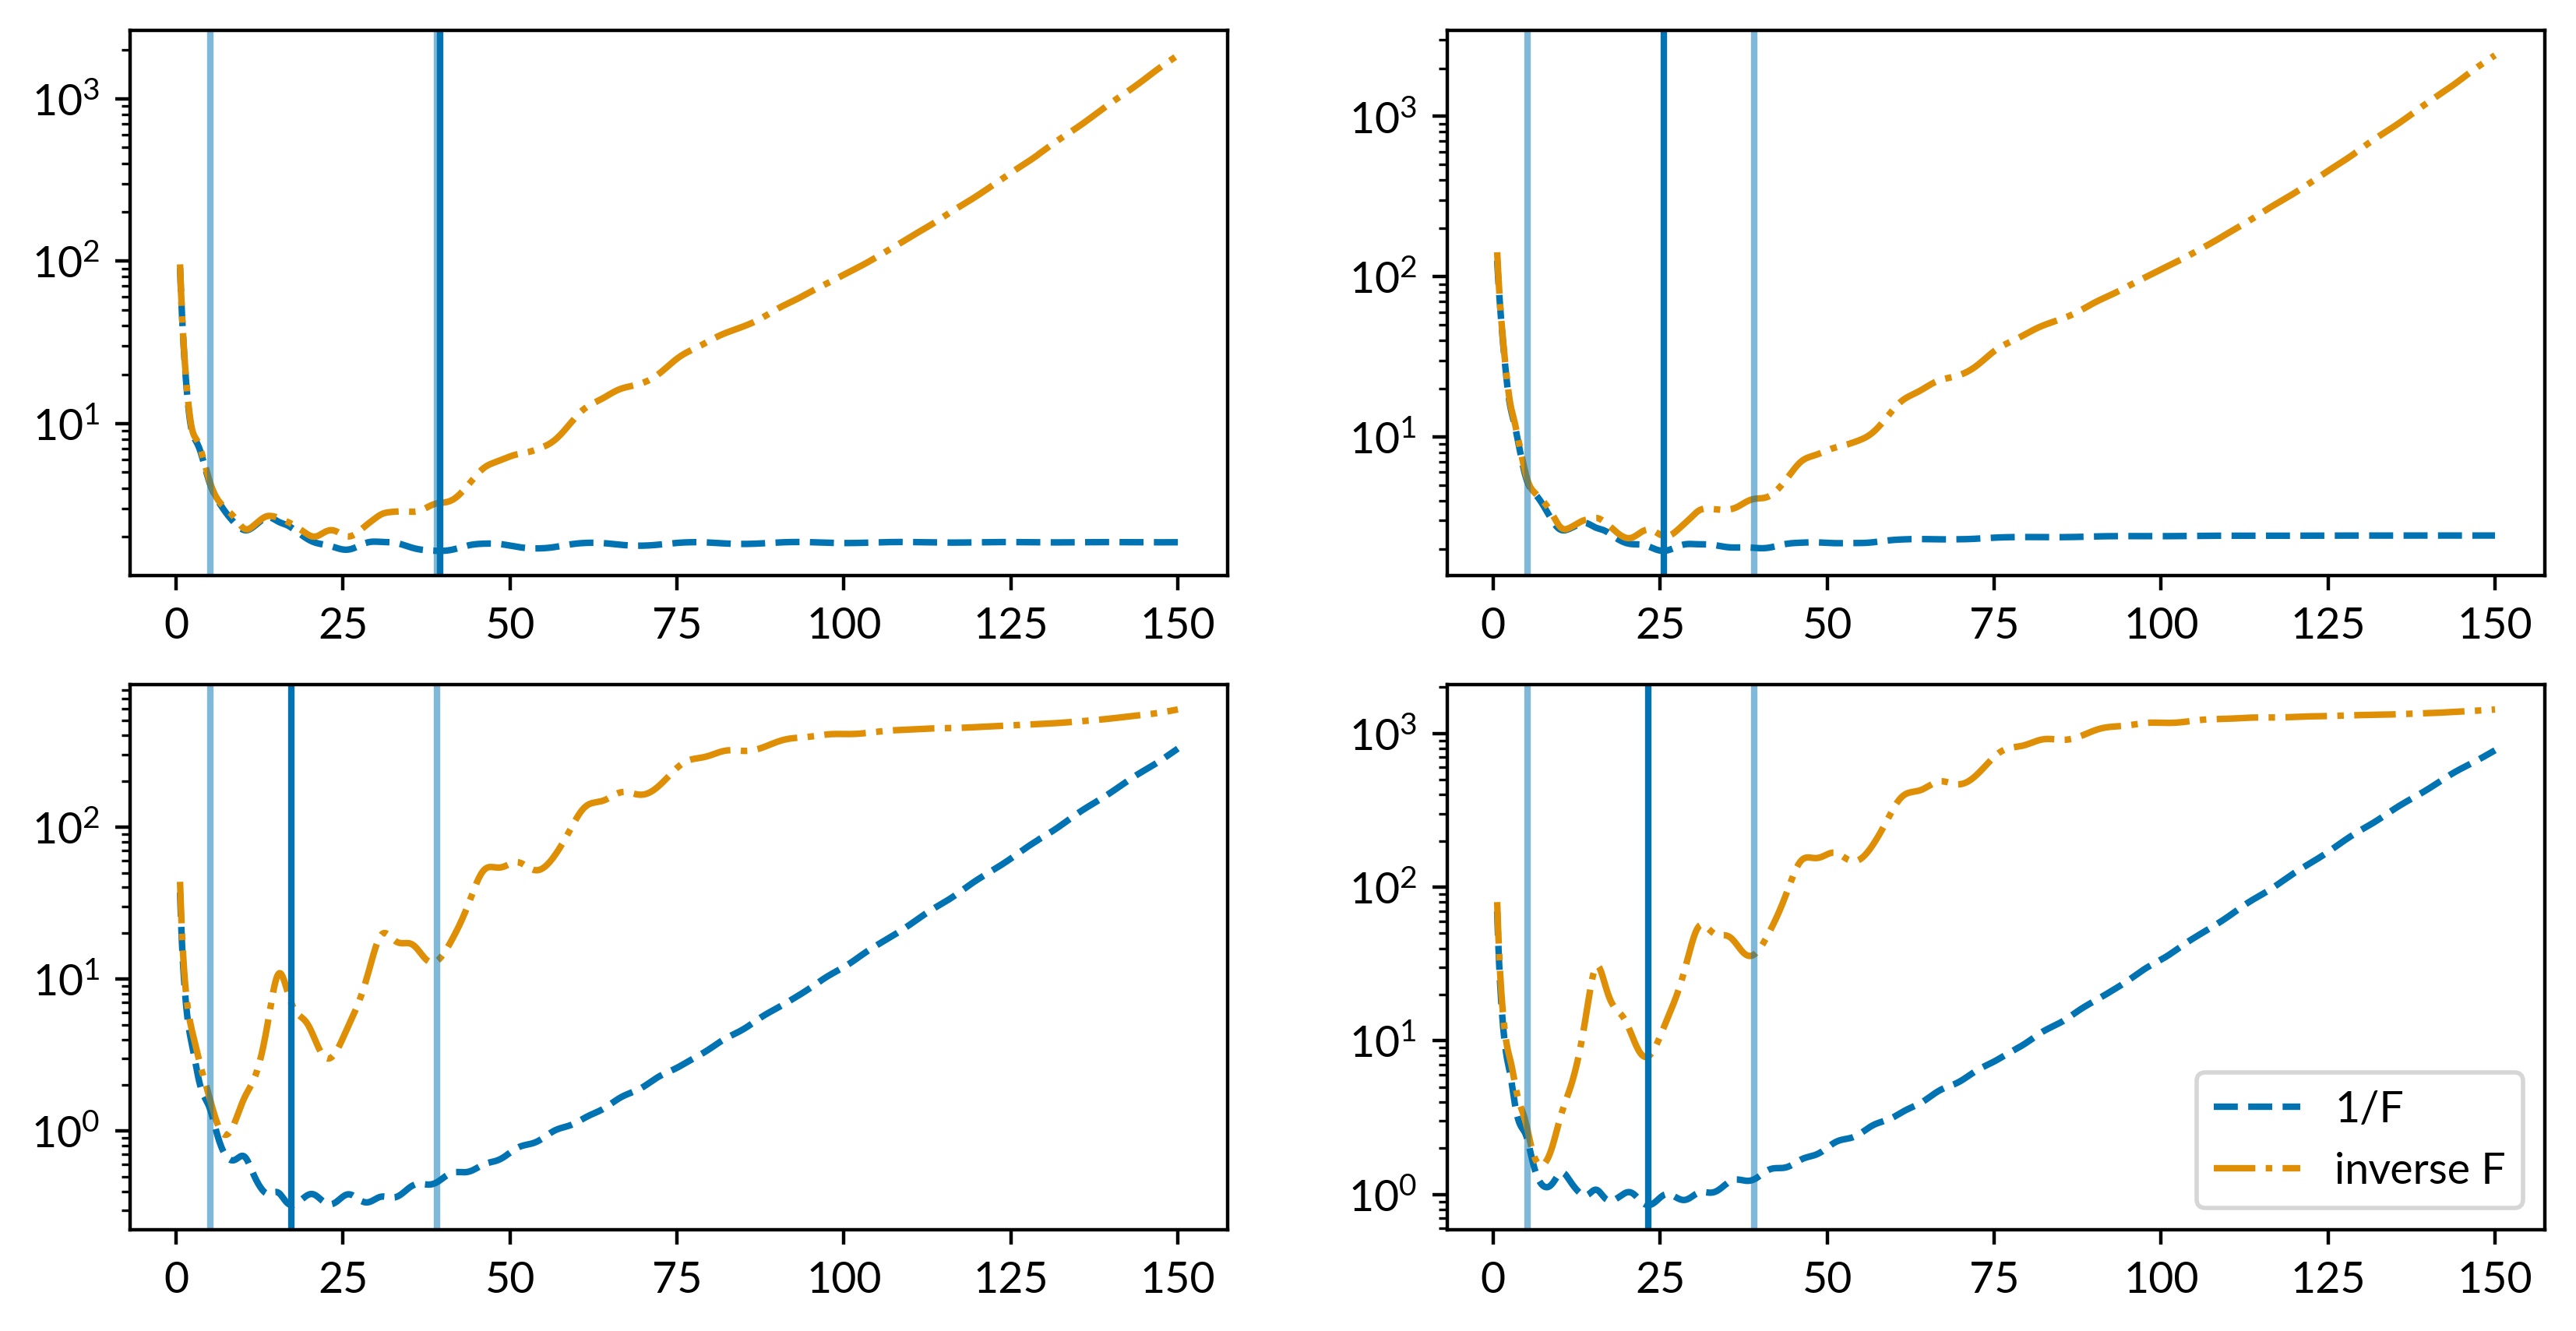

In [104]:
detlim1 = np.argwhere(evolution_det_fim > 1e-2)[0]
detlim2 = np.argwhere(evolution_det_fim > 1e-2)[-1]


fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=400)

for i, ax in enumerate(axs.flat):
    ax.plot(times[4:], 1 / evolution_fim[4:, i, i], "--", label="1/F")

    ax.plot(
        times[4:], evolution_inverse_fim[4:, i, i], "-.", label="inverse F"
    )
    ax.axvline(times[np.diag(np.argmin(1 / evolution_fim[1:], axis=0)) + 1][i])
    # ax.set_xscale("log")
    # ax.plot(times[4:], evolution_det_fim[4:], alpha=0.6)
    ax.axvline(times[detlim1], alpha=0.5)
    ax.axvline(times[detlim2], alpha=0.5)
    ax.set_yscale("log")

plt.legend()

# Study of wtf happens with the scaling

I am gonna plot the trace of the FIM

In [128]:
jnp.diag(evolution_fim[10])/jnp.sqrt(jnp.sum(jnp.diag(evolution_fim[10])**2)))

SyntaxError: unmatched ')' (944851955.py, line 1)

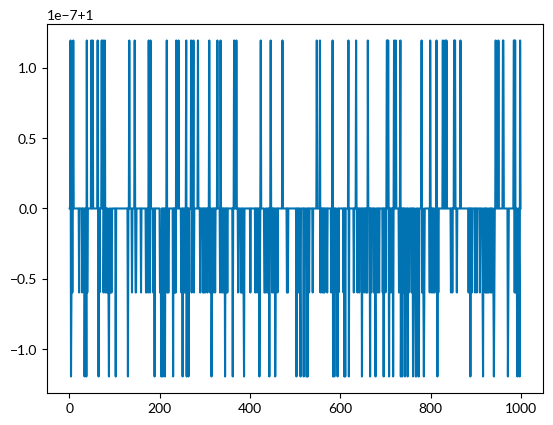

In [114]:
trace_fim_times = jax.vmap(lambda x: jnp.trace(x / jnp.trace(x)))(
    evolution_fim
)

plt.plot(trace_fim_times)

Text(0.5, 0, 'iteration')

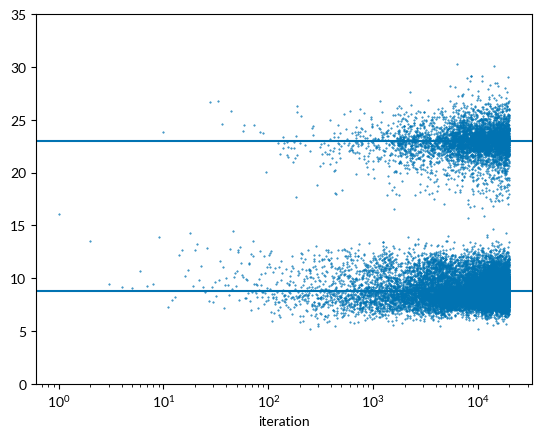

In [163]:
plt.plot(df.times_array[30, 0:], ".", ms=0.9)
plt.ylim(0, 35)
plt.axhline(mu2)
plt.axhline(mu1)


plt.xscale("log")
plt.xlabel("iteration")

(0.0, 40.0)

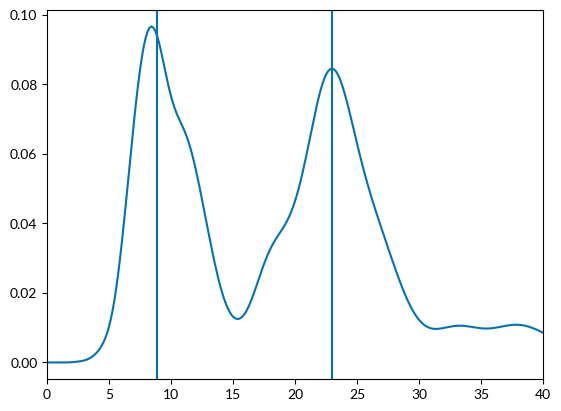

In [160]:
plt.plot(times[1:], evolution_det_fim[1:])
plt.axvline(times[tindex_mu1])
plt.axvline(times[tindex_mu2])
plt.xlim(0, 40)